## 利用机器学习预测足球比赛

准确地讲，本文并非是在预测足球比赛，而是“事后诸葛亮”，通过对比赛各项数据统计与比赛结果进行分析，找出对比赛结果影响最大的因素。这样的分析旨在为真正的预测做些准备。

本文利用机器学习中的监督学习来回答以下问题：
* 足球比赛的数据统计可以在多大的程度上对应比赛结果？
* 哪种足球数据统计与比赛结果最为相关？比如，我们是否应该关注控球率？

### 数据来源
* [欧洲足球数据库](https://www.kaggle.com/hugomathien/soccer)

### 数据准备
* [参照这里](https://github.com/xzl524/football_data_analysis/tree/master/projects/european_soccer_database_analysis/process_ball_events)

### 主要结论

* 主要模型结果总结如下：

|                    模型      |    预测准确率    | 
| :--------------------------------------------------:| :------------: |
| 基准结果：随机猜测                                       |    34.18%      |
| 基准结果：只猜主队赢                                |    46.05%      |
| 随机森林                                       |    57.90%      |
| 泊松回归                                  |    56.00%      |
| 梯度提升                                  |    56.30%      |
| 逻辑回归                                |    56.60%      |
| 线性判别分析                        |    56.60%      |
| 神经网络                                      |    55.80%      |

可以看到，最好的模型预测准确率在56%左右。足球比赛因为有胜平负三种结果，要想准确预测是非常困难的。
* 传中次数在所有数据中对比赛结果的影响排在第二，仅次于射门，高于控球率、角球等等大家非常熟悉的数据。然而截止到2018年，传中次数也并没有作为一个主要的数据被拿来进行报道和讨论。
* 更出人意料地是，传中次数对球队进球的影响是负的，而不是正的。这意味着，传中越多，进球越少。
* 传中是如何影响进球的仍是个迷。这里提一种观点：传中数其实可以看做是反映对手防守质量的一个指标。传中数越多，表示对方的防守越好，本方很难直接打入对方腹地，只能通过传中这样的手段来进攻。
* 不管怎么样，鉴于传中次数对比赛结果的影响，这一数据需要在比赛转播和赛后数据统计中有所体现。

### 监督学习

在足球比赛预测的语境下，监督学习是要找到比赛结果和比赛相关信息之间的一般关联性。掌握这样的关联性后，就可以从比赛相关信息中对比赛结果做出预测。

具体地讲，本文所使用的监督学习模型可以对比赛胜平负出现的可能性进行估计，然后选择最有可能的比赛结果作为最终预测结果。

### 详细内容
#### 1. [数据预处理](#preprocess)
#### 2. [基准结果](#baseline)
#### 3. [模型选择](#model_selection)
#### 4. [模型评估](#model_evaluation)

#### <a id='preprocess'></a>1、数据预处理

In [16]:
%matplotlib inline
import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

sns.set_style('white')
sns.set_context('poster')
sns.set_style({'font.sans-serif':['simhei','Arial']})

print('所有需要的python模块都已导入。')

所有需要的python模块都已导入。


导入数据

In [2]:
# 导入预处理后的比赛数据

# 据实际情况修改数据文件路径
data_folder = os.path.join(os.path.pardir, os.path.pardir, 'data_source', 'kaggle')
match_stats_table_name = 'match_stats.data'

try:
    with open(os.path.join(data_folder, match_stats_table_name), 'rb') as f:
        print('正在导入数据文件...')
        match = pd.read_pickle(f)
        print('成功导入{}.'.format(match_stats_table_name))
except Exception as e:
    print('无法导入{}.'.format(match_stats_table_name))

正在导入数据文件...
成功导入match_stats.data.


合成需要的信息

In [3]:
# 射门相关的数据包括：射正非进球数、射偏数和进球数
shot_events = ['shoton_no_goal', 'shotoff', 'goal']

# 选择主客队射门相关的信息
home_team_feature = ['home_team_{}'.format(i) for i in shot_events]
away_team_feature = ['away_team_{}'.format(i) for i in shot_events]

# 移除缺失数据
for col in home_team_feature + away_team_feature:
    match = match[match[col].notnull()]
    
# 通过射正非进球数和进球数合成射正数
match['home_team_shoton'] = match['home_team_shoton_no_goal'] + match['home_team_goal']
match['away_team_shoton'] = match['away_team_shoton_no_goal'] + match['away_team_goal']

# 合成射门数
match['home_team_shot'] = match['home_team_shoton_no_goal'] + match['home_team_shotoff'] + match['home_team_goal']
match['away_team_shot'] = match['away_team_shoton_no_goal'] + match['away_team_shotoff'] + match['away_team_goal']

# 合成净胜球数
goal_diff = match['home_team_goal'] - match['away_team_goal']

# 对比赛结果进行编码
# 主队获胜：0
# 双方打平：1
# 客队获胜：2
match['result'] = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

print('比赛数据表一共有{}列。每一列代表的是：\n{}\n'.format(match.shape[1], match.columns.values))
print(match.info())
print('\n数据表的最开头两行内容如下：')
match.head(2)

比赛数据表一共有140列。每一列代表的是：
['id' 'country_id' 'league_id' 'season' 'stage' 'date' 'match_api_id'
 'home_team_api_id' 'away_team_api_id' 'home_team_goal' 'away_team_goal'
 'home_player_X1' 'home_player_X2' 'home_player_X3' 'home_player_X4'
 'home_player_X5' 'home_player_X6' 'home_player_X7' 'home_player_X8'
 'home_player_X9' 'home_player_X10' 'home_player_X11' 'away_player_X1'
 'away_player_X2' 'away_player_X3' 'away_player_X4' 'away_player_X5'
 'away_player_X6' 'away_player_X7' 'away_player_X8' 'away_player_X9'
 'away_player_X10' 'away_player_X11' 'home_player_Y1' 'home_player_Y2'
 'home_player_Y3' 'home_player_Y4' 'home_player_Y5' 'home_player_Y6'
 'home_player_Y7' 'home_player_Y8' 'home_player_Y9' 'home_player_Y10'
 'home_player_Y11' 'away_player_Y1' 'away_player_Y2' 'away_player_Y3'
 'away_player_Y4' 'away_player_Y5' 'away_player_Y6' 'away_player_Y7'
 'away_player_Y8' 'away_player_Y9' 'away_player_Y10' 'away_player_Y11'
 'home_player_1' 'home_player_2' 'home_player_3' 'home_player_4'
 'h

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_team_shotoff,away_team_corner,away_team_possession,home_team_days_blm,away_team_days_blm,home_team_shoton,away_team_shoton,home_team_shot,away_team_shot,result
1728,1729,1729,1729,2008/2009,1,2008-08-17,489042,10260,10261,1,...,9.0,6.0,45.25,0.0,0.0,12.0,2.0,22.0,11.0,1
1730,1731,1729,1729,2008/2009,1,2008-08-16,489044,8472,8650,0,...,5.0,8.0,54.50,0.0,0.0,4.0,12.0,7.0,17.0,2


选择比赛相关信息

本文所使用的比赛相关信息包括：犯规数、红黄牌数、传中数、角球数、控球率和射门数。另外，主客队的数据都会使用。

In [4]:
# 选择信息类型
events = ['foulcommit', 'card', 'cross', 'corner', 'possession', 'shot']

event_features = ['home_team_{}'.format(i) for i in events] + ['away_team_{}'.format(i) for i in events]

# 选择需要的列
selected_columns=['country', 'league', 'league_id', 'season', 'stage', 'date', 'home_team',
                  'away_team', 'home_team_goal', 'away_team_goal'] + event_features

match[selected_columns].head()

,country,league,league_id,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,...,home_team_cross,home_team_corner,home_team_possession,home_team_shot,away_team_foulcommit,away_team_card,away_team_cross,away_team_corner,away_team_possession,away_team_shot
1728,England,England Premier League,1729,2008/2009,1,2008-08-17,Manchester United,Newcastle United,1,1,...,24.0,6.0,54.75,22.0,11.0,0.0,9.0,6.0,45.25,11.0
1730,England,England Premier League,1729,2008/2009,1,2008-08-16,Sunderland,Liverpool,0,1,...,15.0,1.0,45.50,7.0,12.0,2.0,19.0,8.0,54.50,17.0
1731,England,England Premier League,1729,2008/2009,1,2008-08-16,West Ham United,Wigan Athletic,2,1,...,15.0,6.0,49.75,14.0,13.0,1.0,27.0,10.0,50.25,23.0
1732,England,England Premier League,1729,2008/2009,1,2008-08-17,Aston Villa,Manchester City,4,2,...,16.0,7.0,51.50,13.0,13.0,1.0,16.0,8.0,48.50,16.0
1733,England,England Premier League,1729,2008/2009,1,2008-08-16,Everton,Blackburn Rovers,2,3,...,14.0,3.0,51.75,11.0,11.0,2.0,21.0,4.0,48.25,19.0


In [5]:
# 确认使用的信息
feature_list = event_features
print(feature_list)

['home_team_foulcommit', 'home_team_card', 'home_team_cross', 'home_team_corner', 'home_team_possession', 'home_team_shot', 'away_team_foulcommit', 'away_team_card', 'away_team_cross', 'away_team_corner', 'away_team_possession', 'away_team_shot']


准备建模数据

In [6]:
# 移除缺失值
match_sel = match
for col in feature_list:
    match_sel = match_sel[match_sel[col].notnull()]
    
# 训练集/测试集划分
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(match_sel, test_size=1000, random_state=42)

Xtrain = train_df[feature_list].values
Xtest = test_df[feature_list].values

y = match_sel['result'].values
ytrain = train_df['result'].values
ytest = test_df['result'].values

hgoaltrain = train_df['home_team_goal'].values
hgoaltest = test_df['home_team_goal'].values

agoaltrain = train_df['away_team_goal'].values
agoaltest = test_df['away_team_goal'].values

In [7]:
# 输入数据正则化
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

Xtrain_norm = mms.fit_transform(Xtrain)
Xtest_norm = mms.transform(Xtest)

In [8]:
print('总数据量：                         {}'.format(match_sel.shape[0]))
print('训练数据量（包括交叉验证数据）：     {}'.format(Xtrain_norm.shape[0]))
print('测试数据量：                       {}'.format(Xtest_norm.shape[0]))

总数据量：                         8124
训练数据量（包括交叉验证数据）：     7124
测试数据量：                       1000


#### <a id='baseline'></a>2、基准结果

首先展示一些基准结果。基准结果可以看做是建模的底线，所有的模型结果需要超过底线才算有效。

#### 2.1 随机猜测

由理论计算可知，随机猜测的准确率为33.33%。

这是因为：假设胜/平/负三种结果出现的概率分别为$p_{w}$，$p_{d}$，和$p_{l}$，那么猜对胜这种结果的概率为$p_{w}*\frac{1}{3}$，猜对打平这种结果的概率为$p_{d}*\frac{1}{3}$，猜对负这种结果的概率为$p_{l}*\frac{1}{3}$。因此，随机猜测的准确率为：

$$\frac{p_w}{3}+\frac{p_d}{3}+\frac{p_l}{3}=\frac{p_w+p_d+p_l}{3}=\frac{1}{3}=33.33\% $$.

通过数据来验证一下：

In [9]:
# 随机猜测
np.random.seed(42)
y_pred = np.random.choice([0,1,2], len(y))
print('随机猜测')
print('预测准确率：             {:.2f}%'.format(accuracy_score(y, y_pred)*100))

随机猜测
预测准确率：             34.18%


这与理论计算结果非常接近。

#### 2.2 只猜主队赢

In [10]:
# 只猜主队赢
y_pred = np.zeros(len(y))
print('只猜主队赢')
print('预测准确率：             {:.2f}%'.format(accuracy_score(y, y_pred)*100))

只猜主队赢
预测准确率：             46.05%


#### 2.3 只猜平局

In [11]:
# 只猜平局
y_pred = np.ones(len(y))
print('只猜平局')
print('预测准确率：             {:.2f}%'.format(accuracy_score(y, y_pred)*100))

只猜平局
预测准确率：             25.28%


#### 2.4 只猜客队赢

In [12]:
# 只猜客队赢
y_pred = 2*np.ones(len(y))
print('只猜客队赢')
print('预测准确率：             {:.2f}%'.format(accuracy_score(y, y_pred)*100))

只猜客队赢
预测准确率：             28.67%


欧洲职业足球比赛胜平负的比率为： 46/25/29。更多细节请参见[这里](https://github.com/xzl524/football_data_analysis/blob/master/projects/european_soccer_database_analysis/exploratory_data_analysis/exploratory_data_analysis_2_CN.ipynb)。

#### <a id='model_selection'></a>3、模型选择

以下为建模的具体步骤。若是对机器学习的概念不甚了解可以略过。

逻辑回归、梯度提升和随机森林可以使用以下相同的代码，利用交叉验证法和对数损失来选择模型的超参数。

#### 3.1 逻辑回归

In [13]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}

#### 3.2 梯度提升

#### 3.3 随机森林

In [14]:
# 使用交叉验证和对数损失来选择超参数
from sklearn.model_selection import validation_curve
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain_norm,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

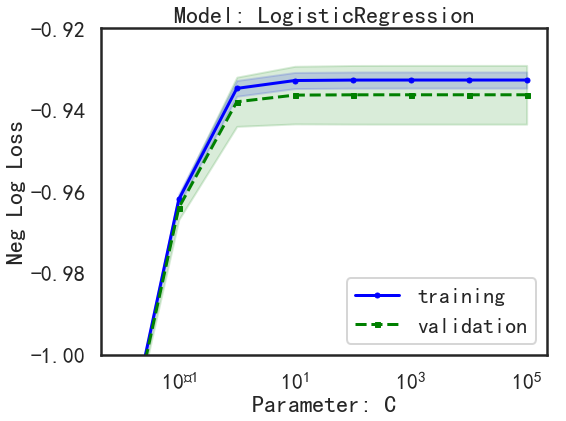

Best C:               100000.0
Neg. log loss (train): -0.9327
Neg. log loss (cv):    -0.9363


In [19]:
plt.figure(figsize=(8,6))
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),train_mean,
         color='blue',marker='o',
         markersize=5,label='training')
plt.fill_between(parameter_dic.get(list(parameter_dic.keys())[0]),
                 train_mean+train_std,
                 train_mean-train_std,
                 alpha=0.15,color='blue')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='validation')
plt.fill_between(parameter_dic.get(list(parameter_dic.keys())[0]),
                 test_mean+test_std,
                 test_mean-test_std,
                 alpha=0.15,color='green')
plt.xlabel('Parameter: {}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('Neg Log Loss')
plt.legend(loc='lower right')
plt.title('Model: {}'.format(clf.__class__.__name__))
plt.xscale('log')
plt.ylim(-1,-0.92)
plt.show()

# print best cross validation result
print('Best {}:               {}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('Neg. log loss (train): {:.4f}'.format(train_mean[np.argmax(test_mean)]))
print('Neg. log loss (cv):    {:.4f}'.format(np.max(test_mean)))

#### 3.4 线性判别分析

线性判别分析没有超参数，但是同样可以使用交叉验证法得到验证集上的结果。

C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warning

train average:            0.9398
cross validation average: 0.9426


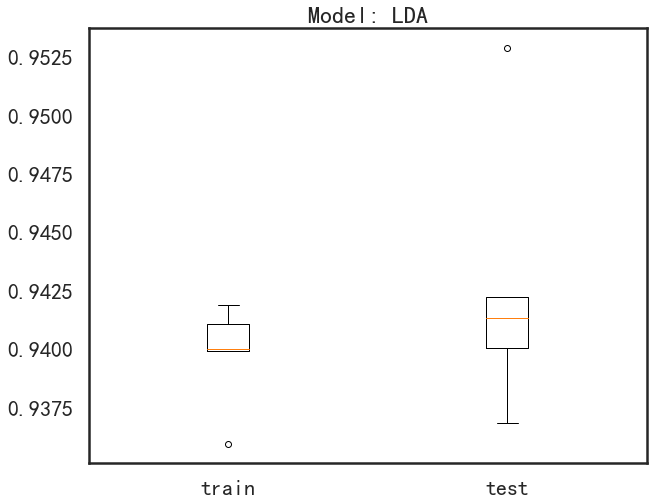

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()

# Calcuate prediction accuracy for cross validation data 
cross_validation_fold = 5

train_scores = []
test_scores = []

kf = StratifiedKFold(n_splits=cross_validation_fold, shuffle=False)
    
for train, test in kf.split(Xtrain_norm, ytrain):
    
    clf.fit(Xtrain_norm[train], ytrain[train])
    train_scores.append(log_loss(ytrain[train], clf.predict_proba(Xtrain_norm[train])))
    test_scores.append(log_loss(ytrain[test], clf.predict_proba(Xtrain_norm[test])))

plt.figure(figsize=(10,8))
plt.boxplot([train_scores, test_scores], labels=['train','test'])
plt.title('Model: LDA')
print('train average:            {:.4f}'.format(np.mean(train_scores)))
print('cross validation average: {:.4f}'.format(np.mean(test_scores)))

#### 3.5 泊松回归

利用泊松回归建模分两步：
* 使用泊松回归模型，由比赛相关信息来估计主队和客队的进球数期望值；
* 比较主客队的进球数期望值，利用泊松分布估计比赛胜平负出现的概率。

In [21]:
from footballmodels import PoissonRegression
clf = PoissonRegression()

train average:            0.9417
cross validation average: 0.9428


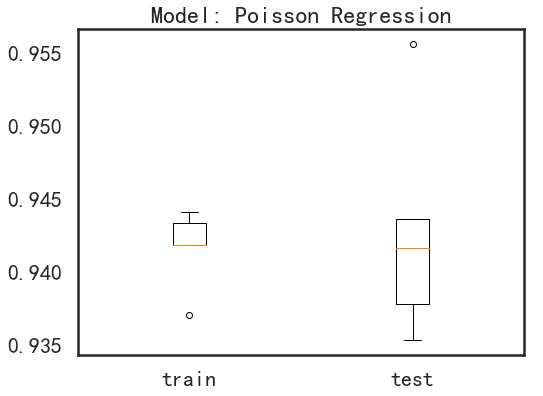

In [23]:
# Calcuate prediction accuracy for cross validation data 
cross_validation_fold = 5

train_scores = []
test_scores = []

kf = StratifiedKFold(n_splits=cross_validation_fold, shuffle=False)
    
for train, test in kf.split(Xtrain_norm, ytrain):
    
    clf.fit(Xtrain_norm[train], Xtrain_norm[train], hgoaltrain[train], agoaltrain[train])
    train_scores.append(log_loss(ytrain[train], clf.predict_proba(Xtrain_norm[train], Xtrain_norm[train])))
    test_scores.append(log_loss(ytrain[test], clf.predict_proba(Xtrain_norm[test], Xtrain_norm[test])))

plt.figure(figsize=(8,6))
plt.boxplot([train_scores, test_scores], labels=['train','test'])
plt.title('Model: Poisson Regression')
print('train average:            {:.4f}'.format(np.mean(train_scores)))
print('cross validation average: {:.4f}'.format(np.mean(test_scores)))

#### 3.6 神经网络

In [44]:
import tensorflow as tf
from tensorflow import keras

In [45]:
# Train validation split
train_x, val_x, train_y, val_y = train_test_split(Xtrain_norm, ytrain, test_size=1000, stratify=ytrain, random_state=42)

In [46]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(Xtrain_norm.shape[1],), ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.train.AdamOptimizer(),
                  metrics=['accuracy'])
    
    return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_x, train_y, epochs=100,
                    validation_data=(val_x, val_y), verbose=0)

The train acc for last epoch is 56.30%
The train loss for last epoch is 0.931
The val acc for last epoch is 56.30%
The val loss for last epoch is 0.937


(0.9, 1)

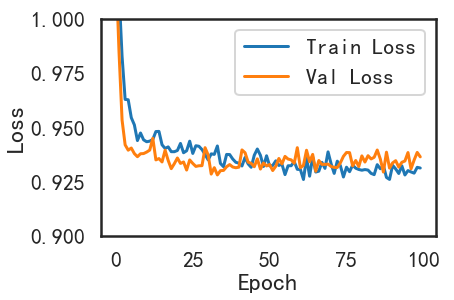

In [47]:
def plot_history(history, kind='acc'):
    plt.figure()
    plt.xlabel('Epoch')
    if kind == 'acc':
        plt.ylabel('Accuracy')
        plt.plot(history.epoch, np.array(history.history['acc']),
                 label='Train Acc')
        plt.plot(history.epoch, np.array(history.history['val_acc']),
                 label = 'Val Acc')
        plt.legend()
    elif kind == 'loss':
        plt.ylabel('Loss')
        plt.plot(history.epoch, np.array(history.history['loss']),
                 label='Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label = 'Val Loss')
        plt.legend()


print('The train acc for last epoch is {:.2f}%'.format(history.history['acc'][-1]*100))
print('The train loss for last epoch is {:.3f}'.format(history.history['loss'][-1]))

print('The val acc for last epoch is {:.2f}%'.format(history.history['val_acc'][-1]*100))
print('The val loss for last epoch is {:.3f}'.format(history.history['val_loss'][-1]))

plot_history(history, kind='loss')
plt.ylim(0.9, 1)

#### <a id='model_evaluation'></a>4、模型评估

下面利用测试集的数据对模型进行评估。

#### 4.1 逻辑回归

In [29]:
from sklearn.linear_model import LogisticRegression
best_clf = LogisticRegression(C=100000, multi_class='auto', solver='liblinear')

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)

# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### Model Evaluation
print('模型：     逻辑回归')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.2f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：     逻辑回归
对数损失：  0.9240
预测准确率：56.60%


#### 4.2 线性判别分析法

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
best_clf = LinearDiscriminantAnalysis()

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)
# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)
#### Model Evaluation
print('模型：     线性判别分析')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.2f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：     线性判别分析
对数损失：  0.9297
预测准确率：56.60%


C:\Users\ZAO_LI_XU\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


#### 4.3 泊松回归

In [31]:
# for poisson regression only
from footballmodels import PoissonRegression
best_clf = PoissonRegression()

best_clf.fit(Xtrain_norm, Xtrain_norm, hgoaltrain, agoaltrain)
ytest_prob = best_clf.predict_proba(Xtest_norm, Xtest_norm)
#### Model Evaluation
print('模型：     泊松回归')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.2f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：     泊松回归
对数损失：  0.9329
预测准确率：56.00%


泊松回归中信息关联性分析

In [32]:
feature_dic = {'home_team_foulcommit': '主队犯规数',
               'home_team_card': '主队红黄牌数',
               'home_team_cross': '主队传中数',
               'home_team_corner': '主队角球数',
               'home_team_possession': '主队控球率',
               'home_team_shot': '主队射门数',
               'away_team_foulcommit': '客队犯规数',
               'away_team_card': '客队红黄牌数',
               'away_team_cross': '客队传中数',
               'away_team_corner': '客队角球数',
               'away_team_possession': '客队控球率',
               'away_team_shot': '客队射门数'}

# 显示中文特征值
feature_list_cn = [feature_dic[key] for key in feature_list]

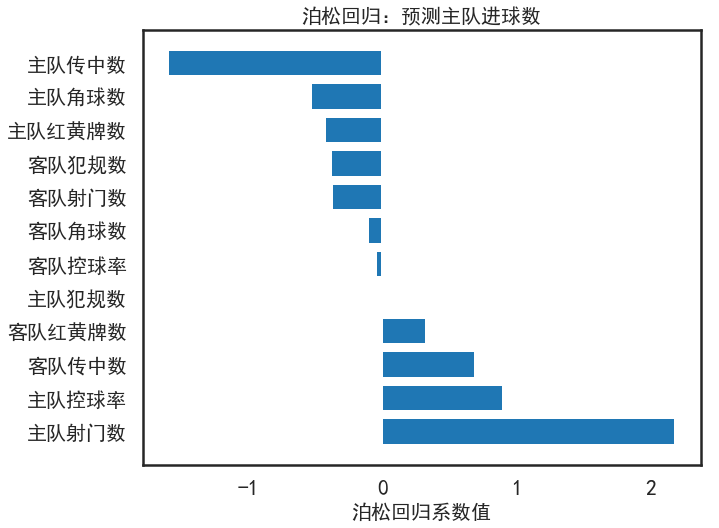

In [34]:
encoded_home_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.hgoal_reg.params, encoded_home_feature_list),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测主队进球数', fontsize=20)
#plt.xlim(-1,1)
plt.show()

可以看到，与主队进球数最相关的是主队射门数，射门越多，进球越多。其次是主队传中数，但是注意，两者的关系是负的，传中越多，进球越少。主队控球率与进球数有一定的关联，但与前两者相比并不明显。

另一方面，与客队进球数最相关的数据是客队射门数，射门越多，进球越多。其次是客队传中数，传中数越多，进球越少。而客队控球率与进球数的关联就微乎其微了。

如何理解这种关联性？

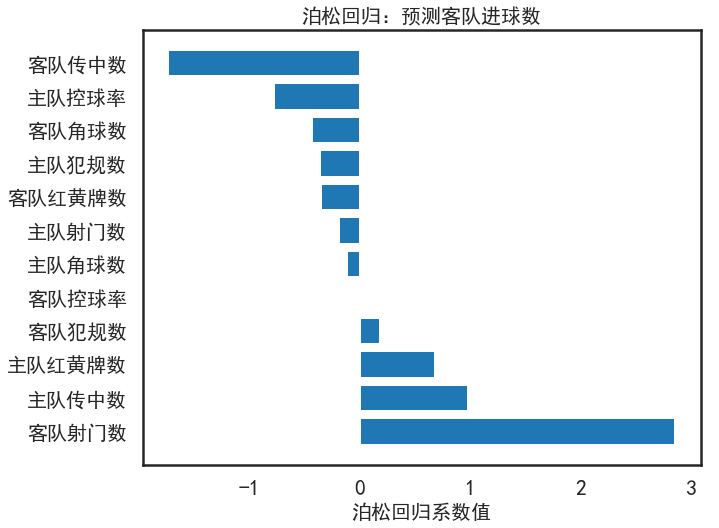

In [35]:
encoded_away_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.agoal_reg.params, encoded_away_feature_list),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测客队进球数', fontsize=20)
#plt.xlim(-1,1)
plt.show()

上面的结果显示，主队传中数越多，主队的进球数就越少。那么，这是否意味着，主队要想多进球，只要尽量不传中就可以了呢？

事实上，并没有这样的结论。这是非常需要注意的一点，也是很容易犯的错误。监督学习之类的数据分析工具只能对不同变量之间的相关性进行分析，而无法验证其中的因果关系。传中数与进球数相关，并不意味着传中与进球就有着必然的因果关系。

监督学习无法说明传中是如何影响进球的。这里提一种观点：传中数其实可以看做是反映对手防守质量的一个指标。传中数越多，表示对方的防守越好，本方很难直接打入对方腹地，只能通过传中这样的手段来进攻。

注意：传中数对比赛的影响并不只在本文的数据上成立，本人使用另外的数据源也能得到同样的结论。除此之外，[这篇论文](https://pdfs.semanticscholar.org/ff66/13c3b46489b88e4c664bf3fee2b42c29b959.pdf)也有同样的结论。

#### 4.4 梯度提升

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
best_clf = GradientBoostingClassifier(max_depth=3, n_estimators=95)

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)
# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)
#### Model Evaluation
print('模型：      梯度提升'.format(best_clf.__class__.__name__))
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.2f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：      梯度提升
对数损失：  0.9329
预测准确率：56.30%


特征重要性分析

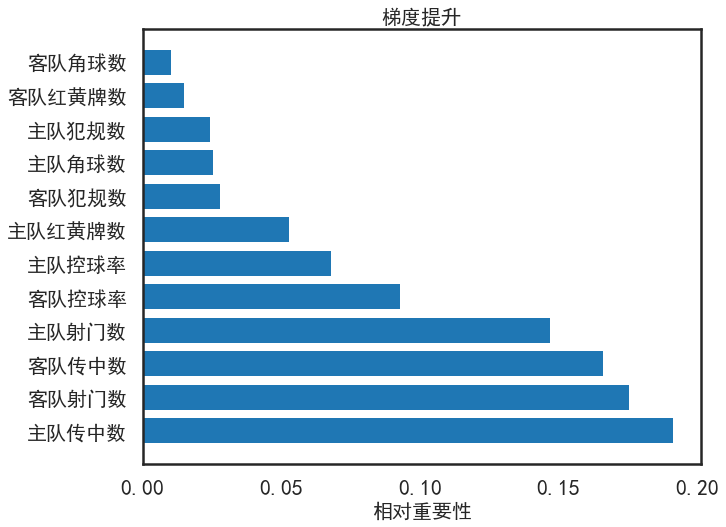

In [49]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list_cn),reverse=True))
plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list, fontsize=20)
plt.xlabel('相对重要性', fontsize=20)
plt.title('梯度提升', fontsize=20)
plt.show()

同样地，传中数和射门数在梯度提升模型中对比赛结果的影响最大。

#### 4.5 随机森林

In [39]:
from sklearn.ensemble import RandomForestClassifier
best_clf = RandomForestClassifier(max_features=3, n_estimators=210)

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)
# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)
#### Model Evaluation
print('Model Evaluation ({})'.format(best_clf.__class__.__name__))
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.2f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (RandomForestClassifier)
Log Loss:                   0.9464
Prediction Accuracy:        57.90%


特征重要性分析

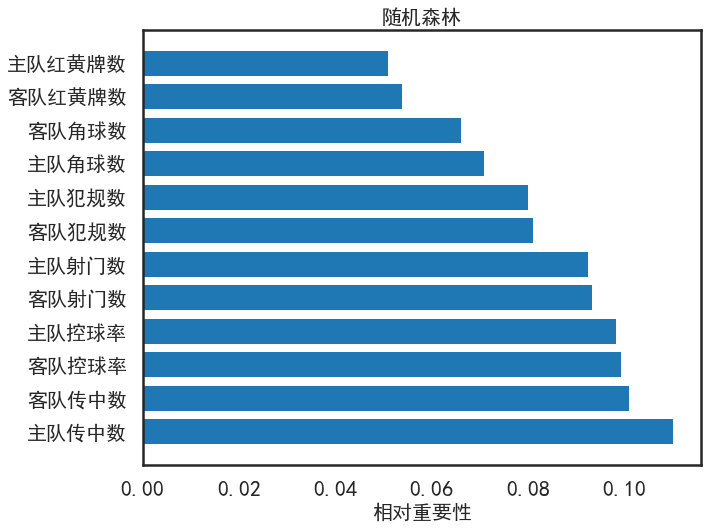

In [40]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list_cn),reverse=True))
plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list, fontsize=20)
plt.xlabel('相对重要性', fontsize=20)
plt.title('随机森林', fontsize=20)
plt.show()

在随机森林中，传中数的影响排在了第一，其次是控球率，然后才是射门数。

#### 4.6 神经网络

In [50]:
# for neural network only
model.fit(Xtrain_norm, ytrain, epochs=100, verbose=0)
ytest_prob = model.predict_proba(Xtest_norm)

#### Model Evaluation
print('模型：      神经网络')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.2f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

模型：      神经网络
对数损失：  0.9282
预测准确率：55.80%
